In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import ipywidgets as widgets

In [2]:
def statistic_of_ensemble(S, mu, var, scale, pdf_resolution, num_samples=10000, kernel='tophat', bandwidth=0.1):
    result_x = []
    result_pdf = []
    result_mu = []
    result_var = []

    std = np.sqrt(var)

    alpha = np.linspace(0, 1, scale + 1)
    v_sample = np.linspace(mu.min() - 3 * std.max(), mu.max() + 3 * std.max(), pdf_resolution).reshape((-1,1))
    for i in range(S.shape[0] - 1):
        s_interpolated = np.linspace(S[i], S[i + 1], scale + 1)

        s1 = np.random.normal(mu[i], std[i], num_samples)
        s2 = np.random.normal(mu[i+1], std[i+1], num_samples)

        v = np.array([a * s2 + (1-a) * s1 for a in alpha])

        result_mu.append( np.mean(v, axis=1) )
        result_var.append( np.var(v, axis=1) )

        pdfs = np.empty((scale + 1,pdf_resolution))
        for idx in range(scale+1):
            kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(v[idx,:].reshape((-1,1)))
            pdfs[idx,:] = np.exp(kde.score_samples(v_sample))

        result_x.append(s_interpolated)
        result_pdf.append(pdfs)

    return result_x, v_sample.flatten(), result_pdf, result_mu, result_var

def moment(S, mu, var, scale):
    result_x = []
    result_mu = []
    result_var = []

    for i in range(S.shape[0] - 1):
        s_interpolated = np.linspace(S[i], S[i + 1], scale + 1)

        mu_interpolated = np.interp(s_interpolated, S[i:i + 2], mu[i:i + 2])
        var_interpolated = np.interp(s_interpolated, S[i:i + 2], var[i:i + 2])

        result_x.append(s_interpolated)
        result_mu.append(mu_interpolated)
        result_var.append(var_interpolated)

    return result_x, result_mu, result_var

# Input Data

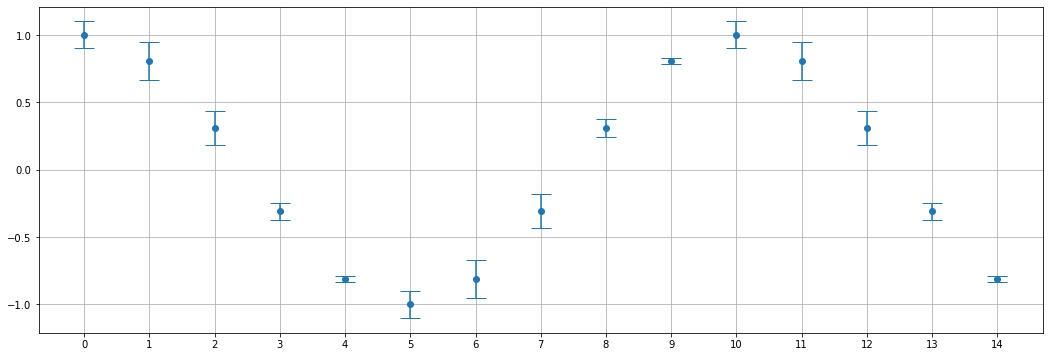

In [3]:
x = np.arange(15)

f = np.cos( x * np.pi/5 )
var_i = np.sin( x * np.pi/2.5 ) * 0.01 + 0.01

plt.figure(figsize=(18,6))
plt.errorbar(x, f, yerr=np.sqrt(var_i), fmt='o', color='tab:blue', capsize=10)
plt.xticks(x)
plt.grid()
plt.show()

In [19]:
scale = 8

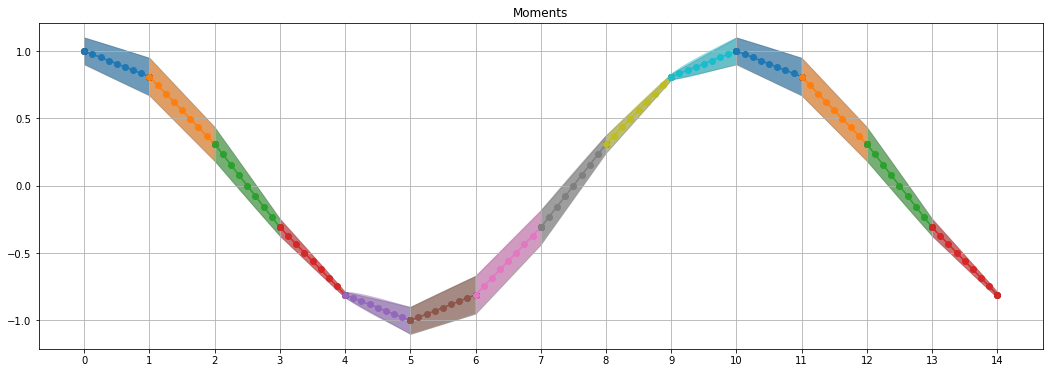

In [20]:
x_moment, mu_moment, var_moment = moment(x, f, var_i, scale)
std_moment = [np.sqrt(var) for var in var_moment]

plt.figure(figsize=(18,6))
plt.title('Moments')
plt.plot(x, f, marker='o', ls='none', c='k')
plt.fill_between(x, f - np.sqrt(var_i), f + np.sqrt(var_i), color='k', alpha=0.25)
for i in range(len(x_moment)):
    plt.plot(x_moment[i], mu_moment[i], marker='o')
    segement = plt.fill_between(x_moment[i], mu_moment[i] - std_moment[i], mu_moment[i] + std_moment[i], alpha=0.5)

plt.xticks(x)
plt.grid()
plt.show()

In [27]:
T_v = 100
x_soe, v_soe, pdf_soe, mu_soe, var_soe = statistic_of_ensemble(x, f, var_i, scale, T_v, kernel='gaussian')
std_soe = [np.sqrt(var) for var in var_soe]

@widgets.interact(idx=widgets.IntSlider(0, 0, scale * len(x_soe)-1, 1, layout=widgets.Layout(width='1000px')))
def show_pdf(idx=8):
    plt.figure(figsize=(30,10))
    plt.title('SOE')
    plt.subplot(2,1,1)
    for i in range(len(x_soe)):
        extent = [
            x_soe[i][0] * scale - 1 if i > 0 else x_soe[i][0] * scale,
            x_soe[i][-1] * scale,
            v_soe[0],
            v_soe[-1]
        ]
        plt.imshow(pdf_soe[i].T, cmap='Reds', origin='lower', extent=extent, aspect='auto', interpolation='None')

    plt.vlines(idx, v_soe[0], v_soe[-1], colors='tab:blue', ls='dashed')
    plt.xlim(0, scale * len(x_soe))
    plt.xticks(np.arange(0, scale * len(x_soe)+1, scale), x)
    plt.grid()
    plt.colorbar()

    plt.subplot(2,1,2)
    plt.title(r'$\mu = {:.02f}, \sigma^2 = {:.04f}$'.format( mu_soe[idx // scale][idx % scale], var_soe[idx // scale][idx % scale] ))
    plt.plot(v_soe, pdf_soe[idx // scale][idx % scale].T)
    if idx > 0 and idx % scale == 0:
        plt.plot(v_soe, pdf_soe[(idx+1) // scale][0].T)
        plt.legend(['segment {:d}'.format(idx // scale), 'segment {:d}'.format(idx // scale + 1)])
    plt.xlim(v_soe[0], v_soe[-1])
    plt.ylim(0,8)
    plt.grid()

    plt.show()

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='1000px'), max=111), Output())…

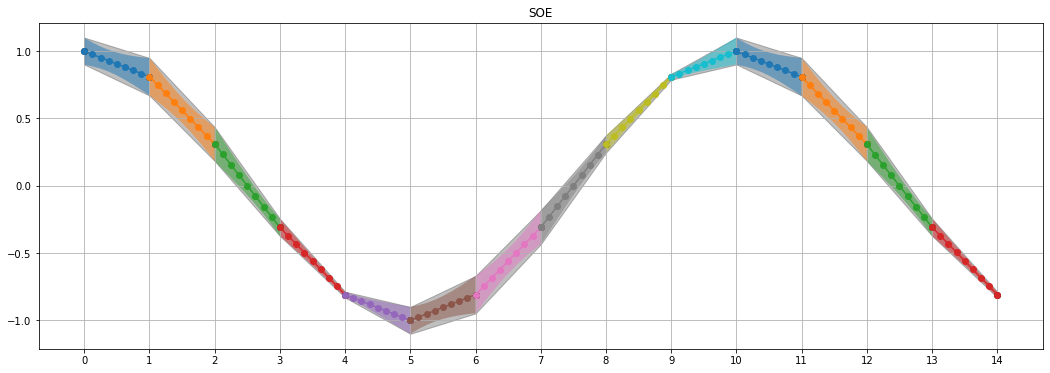

In [28]:
plt.figure(figsize=(18,6))
plt.title('SOE')
plt.plot(x, f, marker='o', ls='none', c='k')
plt.fill_between(x, f - np.sqrt(var_i), f + np.sqrt(var_i), color='k', alpha=0.25)
for i in range(len(x_soe)):
    plt.plot(x_soe[i], mu_soe[i], marker='o')
    segement = plt.fill_between(x_soe[i], mu_soe[i] - std_soe[i], mu_soe[i] + std_soe[i], alpha=0.5)

plt.xticks(x)
plt.grid()
plt.show()

In [6]:
def wasserstein(mu1, var1, mu2, var2):
    return np.sqrt(
        ( mu1 - mu2 )**2 + ( np.sqrt(var1) - np.sqrt(var2) )**2
    )

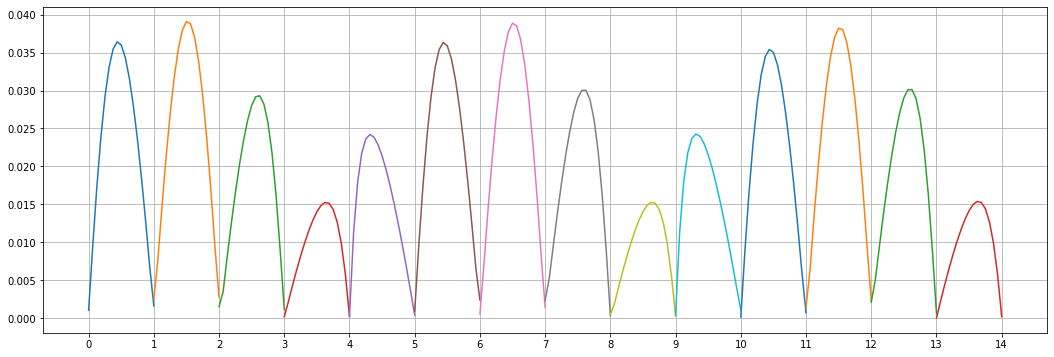

In [13]:
plt.figure(figsize=(18,6))
for i in range(len(x_moment)):
    diff = wasserstein(mu_soe[i], var_soe[i], mu_moment[i], var_moment[i])

    plt.plot(x_moment[i], diff)

plt.xticks(x)
plt.grid()
plt.show()